In [ ]:
!pip install Flask flask-ngrok


In [ ]:
!pip install pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# Load data from CSV
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
data = pd.read_csv(csv_file)
print(data.head())

     id Type PromoterName                               SpeciesName GeneName  \
0  4759  chr       aaeBp3  Escherichia coli str K-12 substr. MG1655     aaeB   
1  4760  chr       aaeBp7  Escherichia coli str K-12 substr. MG1655     aaeB   
2  4761  chr       aaeBp8  Escherichia coli str K-12 substr. MG1655     aaeB   
3  4762  chr        aaeRp  Escherichia coli str K-12 substr. MG1655     aaeR   
4  4763  chr      aaeRp10  Escherichia coli str K-12 substr. MG1655     aaeR   

   GeneStart    GeneEnd                                        GeneProduct  \
0  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
1  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
2  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
3  3389520.0  3390449.0           LysR-type transcriptional regulator AaeR   
4  3389520.0  3390449.0           LysR-type transcriptional regulator AaeR   

   TSSPosition Strand Locus_tag  \
0      3388263 

In [ ]:
import requests
def find_operon_by_gene(gene_name):
    # Define the endpoint URL for the GraphQL API
    url = 'https://a846-41-79-97-5.ngrok-free.app/graphql'

    # Define the GraphQL query with a variable for the gene name
    query = """
    query ($geneName: String!) {
      getOperonBy(search: $geneName) {
        data {
          operon {
            _id
            name
            strand
          }
          transcriptionUnits {
            name
            promoter {
              name
              confidenceLevel
              regulatorBindingSites {
                function
              }
            }
            genes {
              name
            }
          }
        }
      }
    }
    """

    # Define the headers
    headers = {
        'Content-Type': 'application/json'
    }

    # Define the payload with variables
    payload = {
        'query': query,
        'variables': {
            'geneName': gene_name
        }
    }

    # Send the request
    response = requests.post(url, json=payload, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        print(data)
    else:
        print(f"Query failed to run with a {response.status_code}.")
        print(response.text)  # Print the response text to debug the issue

# Example usage
gene_name = "ymdA"  # Replace with the gene name provided by the user
find_operon_by_gene(gene_name)

{'data': {'getOperonBy': {'data': [{'operon': {'_id': 'RDBECOLIOPC02870', 'name': 'ymdAB-clsC', 'strand': 'forward'}, 'transcriptionUnits': [{'name': 'ymdA', 'promoter': {'name': 'ymdAp', 'confidenceLevel': 'S', 'regulatorBindingSites': []}, 'genes': [{'name': 'ymdA'}]}, {'name': 'ymdB-clsC', 'promoter': {'name': 'ymdBp', 'confidenceLevel': 'S', 'regulatorBindingSites': []}, 'genes': [{'name': 'clsC'}, {'name': 'ymdB'}]}, {'name': 'clsC', 'promoter': {'name': 'clsCp', 'confidenceLevel': 'S', 'regulatorBindingSites': []}, 'genes': [{'name': 'clsC'}]}, {'name': 'ymdAB-clsC', 'promoter': {'name': 'ymdAp', 'confidenceLevel': 'S', 'regulatorBindingSites': []}, 'genes': [{'name': 'clsC'}, {'name': 'ymdB'}, {'name': 'ymdA'}]}, {'name': 'ymdB', 'promoter': {'name': 'ymdBp', 'confidenceLevel': 'S', 'regulatorBindingSites': []}, 'genes': [{'name': 'ymdB'}]}, {'name': 'ymdAB', 'promoter': {'name': 'ymdAp', 'confidenceLevel': 'S', 'regulatorBindingSites': []}, 'genes': [{'name': 'ymdB'}, {'name': 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract promoter sequences and efficacy (if available)
promoter_sequences = data['PromoterSeq']
gene_names = data['GeneName']

data['Effective'] = (data['GeneProduct'].notna()).astype(int)
promoter_sequences = promoter_sequences.fillna('')

vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))  # 3-mer
X_promoter = vectorizer.fit_transform(promoter_sequences).toarray()
y = data['Effective'].values

# Display the shape of the resulting feature matrix
print(X_promoter.shape)

(3586, 70)


In [ ]:
import requests
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np # Added import for numpy

def find_operon_by_gene(gene_name):
    url = 'https://a846-41-79-97-5.ngrok-free.app/graphql'

    # Define the GraphQL query with a variable for the gene name
    query = """
    query ($geneName: String!) {
      getOperonBy(search: $geneName) {
        data {
          operon {
            _id
            name
            strand
          }
          transcriptionUnits {
            name
            promoter {
              name
              confidenceLevel
              regulatorBindingSites {
                function
              }
            }
            genes {
              name
            }
          }
        }
      }
    }
    """

    # Define the headers
    headers = {'Content-Type': 'application/json' }

    # Define the payload with variables
    payload = {
        'query': query,
        'variables': {
            'geneName': gene_name
        }
    }
    response = requests.post(url, json=payload, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Query failed to run with a {response.status_code}.")
        print(response.text)  # Print the response text to debug the issue
        return None

gene_name = "ymdA"  # Replace with the gene name provided by the user
operon_data = find_operon_by_gene(gene_name)

# Assuming you have a CSV file to use for machine learning
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
gene_data = pd.read_csv(csv_file)

if operon_data:
    # Extract promoter sequences and efficacy (if available)
    promoter_sequences = gene_data['PromoterSeq']
    gene_names = gene_data['GeneName']

    gene_data['Locus_tag'] = (gene_data['GeneProduct'].notna()).astype(int)
    promoter_sequences = promoter_sequences.fillna('')

    vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))  # 3-mer
    X_promoter = vectorizer.fit_transform(promoter_sequences).toarray()
    y = gene_data['Locus_tag'].values

    # Display the shape of the resulting feature matrix
    print(X_promoter.shape)

    # Check for class imbalance
    if len(np.unique(y)) < 2:
        print("Warning: The target variable has only one class. SVM training will likely fail.")
        # Handle the imbalance (e.g., collect more data, use a different model, etc.)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_promoter, y, test_size=0.2, random_state=42)
        model = SVC(probability=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)

        print(f'Accuracy: {accuracy}')
        print(f'ROC-AUC: {roc_auc}')
else:
    print("No operon data available.")

(3586, 70)


In [ ]:
def optimize_promoter_gene(df, model, vectorizer):
    best_score = 0
    best_config = None

    # Use df instead of data to refer to the DataFrame
    for _, row in data.iterrows():
        promoter_seq = row['PromoterSeq']
        gene_name = row['GeneName']

        # Handle potential NaN values in promoter sequences
        if pd.isna(promoter_seq):
            promoter_seq = ''  # Replace NaN with empty string

        # Transform the promoter sequence into features
        X_promoter = vectorizer.transform([promoter_seq]).toarray()
        efficacy_prob = model.predict_proba(X_promoter)[:, 1][0]

        if efficacy_prob > best_score:
            best_score = efficacy_prob
            best_config = {
                'PromoterSeq': promoter_seq,
                'GeneName': gene_name,
                'PredictedEfficacy': efficacy_prob
            }
    return best_config

# Assuming gene_data is the DataFrame you want to use
best_config = optimize_promoter_gene(gene_data, model, vectorizer)
print(f'Best Configuration: {best_config}')

(3586, 70)


In [ ]:
import pandas as pd

# Load data from CSV
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
df = pd.read_csv(csv_file)

# Display the first few rows of the dataframe
print(df.head())

     id Type PromoterName                               SpeciesName GeneName  \
0  4759  chr       aaeBp3  Escherichia coli str K-12 substr. MG1655     aaeB   
1  4760  chr       aaeBp7  Escherichia coli str K-12 substr. MG1655     aaeB   
2  4761  chr       aaeBp8  Escherichia coli str K-12 substr. MG1655     aaeB   
3  4762  chr        aaeRp  Escherichia coli str K-12 substr. MG1655     aaeR   
4  4763  chr      aaeRp10  Escherichia coli str K-12 substr. MG1655     aaeR   

   GeneStart    GeneEnd                                        GeneProduct  \
0  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
1  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
2  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
3  3389520.0  3390449.0           LysR-type transcriptional regulator AaeR   
4  3389520.0  3390449.0           LysR-type transcriptional regulator AaeR   

   TSSPosition Strand Locus_tag  \
0      3388263 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract promoter sequences and efficacy (if available)
promoter_sequences = data['PromoterSeq']
gene_names = data['GeneName']

# Example efficacy column; in practice, you need to provide this
# For demonstration, I'm assuming a binary efficacy column 'Effective'
data['Locus_tag'] = (data['regulation'].notna()).astype(int)

# Handle missing values in promoter sequences (replace NaN with empty string)
promoter_sequences = promoter_sequences.fillna('')

# Use CountVectorizer to create k-mer features
vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))  # 3-mer
X_promoter = vectorizer.fit_transform(promoter_sequences).toarray()
y = data['Locus_tag'].values

# Display the shape of the resulting feature matrix
print(X_promoter.shape)

(3586, 70)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_promoter, y, test_size=0.2, random_state=42)

# Train an SVM model
model = SVC(probability=True)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'ROC-AUC: {roc_auc}')

Accuracy: 0.7047353760445683
ROC-AUC: 0.7367821547223541


In [ ]:
import numpy as np

def optimize_promoter_gene(df, model, vectorizer):
    best_score = 0
    best_config = None

    for _, row in data.iterrows():
        promoter_seq = row['PromoterSeq']
        gene_name = row['GeneName']

        # Handle potential NaN values in promoter sequences
        if pd.isna(promoter_seq):
            promoter_seq = ''  # Replace NaN with empty string

        # Transform the promoter sequence into features
        X_promoter = vectorizer.transform([promoter_seq]).toarray()

        # Predict efficacy
        efficacy_prob = model.predict_proba(X_promoter)[:, 1][0]

        if efficacy_prob > best_score:
            best_score = efficacy_prob
            best_config = {
                'PromoterSeq': promoter_seq,
                'GeneName': gene_name,
                'PredictedEfficacy': efficacy_prob
            }

    return best_config

# Optimize promoter-gene configurations
best_config = optimize_promoter_gene(data, model, vectorizer)
print(f'Best Configuration: {best_config}')

Best Configuration: {'PromoterSeq': 'attactaatataaataaattttgcttgattcatgcaagcggcattaatactatttatactAacgtcaatatacaacccacc', 'GeneName': 'gspC', 'PredictedEfficacy': 0.9258521983542954}


In [ ]:
import pandas as pd
# Load the CSV file
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
data = pd.read_csv(csv_file)
print(data.head())


     id Type PromoterName                               SpeciesName GeneName  \
0  4759  chr       aaeBp3  Escherichia coli str K-12 substr. MG1655     aaeB   
1  4760  chr       aaeBp7  Escherichia coli str K-12 substr. MG1655     aaeB   
2  4761  chr       aaeBp8  Escherichia coli str K-12 substr. MG1655     aaeB   
3  4762  chr        aaeRp  Escherichia coli str K-12 substr. MG1655     aaeR   
4  4763  chr      aaeRp10  Escherichia coli str K-12 substr. MG1655     aaeR   

   GeneStart    GeneEnd                                        GeneProduct  \
0  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
1  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
2  3388188.0  3386221.0  aromatic carboxylic acid efflux pump subunit AaeB   
3  3389520.0  3390449.0           LysR-type transcriptional regulator AaeR   
4  3389520.0  3390449.0           LysR-type transcriptional regulator AaeR   

   TSSPosition Strand Locus_tag  \
0      3388263 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Extract the GeneProduct column
gene_products = data['GeneProduct']
tfidf_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
X = tfidf_vectorizer.fit_transform(gene_products)

print(X.shape)

# Define the target variable with extended classification
def classify_gene_product(gene_product):
    if 'binding' in gene_product:
        return 'binding'
    elif 'transcription' in gene_product:
        return 'transcription'
    elif 'protein' in gene_product:
        return 'protein'
    elif 'regulator' in gene_product:
        return 'regulator'
    elif 'DNA-binding' in gene_product:
        return 'DNA-binding'
    else:
        return 'other'

data['Class'] = data['GeneProduct'].apply(classify_gene_product)

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Class'])
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
cross_val_scores = cross_val_score(clf, X_res, y_res, cv=5)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Average cross-validation score: {cross_val_scores.mean()}")
gene_to_product = dict(zip(data['GeneName'], data['GeneProduct']))


(3586, 300)
               precision    recall  f1-score   support

      binding       1.00      1.00      1.00       535
        other       0.95      1.00      0.98       570
      protein       1.00      0.96      0.98       564
    regulator       1.00      0.99      0.99       561
transcription       1.00      1.00      1.00       544

     accuracy                           0.99      2774
    macro avg       0.99      0.99      0.99      2774
 weighted avg       0.99      0.99      0.99      2774

Cross-validation scores: [0.97836668 0.99242834 0.99459167 0.996755   0.98864251]
Average cross-validation score: 0.9901568415359655


In [ ]:
def classify_gene_name(gene_name):
    gene_product = gene_to_product.get(gene_name, "")
    if gene_product == "":
        return "Unknown gene name"
    features = tfidf_vectorizer.transform([gene_product])
    # Predict the class
    predicted_class = clf.predict(features)
    # Return the gene product and the predicted class label
    return gene_product, label_encoder.inverse_transform(predicted_class)[0]

# Example usage
new_gene_name = "mutL"
gene_product, predicted_class = classify_gene_name(new_gene_name)
print(f"The gene product for the gene '{new_gene_name}' is '{gene_product}'")
print(f"The predicted class is '{predicted_class}'")

The gene product for the gene 'mutL' is 'DNA mismatch repair protein MutL'
The predicted class is 'protein'


In [ ]:
import networkx as nx # Import the networkx library
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np

# Create a sample graph (replace with your actual graph data)
G = nx.karate_club_graph() # Example graph

node_labels = []
node_features = []
for node, data in G.nodes(data=True):
    # Check if 'type' attribute exists, if not, assign a default value or skip the node
    node_type = data.get('Locus_tag')
    if node_type is None:
        node_type = 'unknown'  # Assign a default type

    node_labels.append(node_type)
    node_features.append([
        G.degree[node],
        nx.betweenness_centrality(G)[node],
        nx.clustering(G)[node]
    ])

features_df = pd.DataFrame(node_features, columns=['degree', 'betweenness_centrality', 'clustering'])
labels_df = pd.DataFrame(node_labels, columns=['Locus_tag'])

target_variable = np.random.rand(len(features_df)) # Create a random continuous target variable for nodes in features_df

# Split the data into features and labels
X = features_df.values
y = target_variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the regressor and parameter grid for hyperparameter tuning
reg = Ridge(random_state=42)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(reg, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

# Print the best parameters and the mean squared error
print("Best parameters:", grid_search.best_params_)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 100}
Mean Squared Error: 0.10728449963804207


In [ ]:
import requests
import pandas as pd

def fetch_operon_data(gene_name):
    url = 'https://2a4e-102-69-221-221.ngrok-free.app/graphql'
    query = """
    query ($geneName: String!) {
      getOperonBy(search: $geneName) {
        data {
          operon {
            _id
            name
            strand
          }
          transcriptionUnits {
            name
            promoter {
              name
              confidenceLevel
              regulatorBindingSites {
                function
              }
            }
            genes {
              name
            }
          }
        }
      }
    }
    """
    headers = {'Content-Type': 'application/json'}
    payload = {'query': query, 'variables': {'geneName': gene_name}}

    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data['data']['getOperonBy']['data']:
            return data
        else:
            print("No data found for the given gene name.")
            return None
    else:
        print(f"Query failed to run with a {response.status_code}.")
        print(response.text)
        return None

def load_gene_data(csv_file):
    return pd.read_csv(csv_file)

In [ ]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Function to query GraphQL
def query_graphql(endpoint, query, variables=None):
    headers = {'Content-Type': 'application/json'}
    response = requests.post(endpoint, json={"query": query, "variables": variables}, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed to run with a {response.status_code}. Response: {response.text}")

# Define the endpoint URL for the GraphQL API
endpoint =  'https://a846-41-79-97-5.ngrok-free.app/graphql'

# Query to get operons and their genes
operon_query = """
{
  getAllOperon(limit: 10) {
    data {
      operon {
        _id
        name
        strand
      }
      transcriptionUnits {
        _id
        name
        promoter {
          name
          confidenceLevel
          regulatorBindingSites {
            function
          }
        }
        genes {
          name
        }
      }
    }
  }
}
"""

operon_data = query_graphql(endpoint, operon_query)

# Extract gene names from operon data
gene_names = []
for operon in operon_data['data']['getAllOperon']['data']:
    for tu in operon['transcriptionUnits']:
        for gene in tu['genes']:
            gene_names.append(gene['name'])

# Query to get gene details by name
def get_gene_details_by_name(gene_name):
    query = """
    {
      getGenesBy(search: "%s") {
        data {
          gene {
            _id
            name
            leftEndPosition
            rightEndPosition
            type
          }
        }
      }
    }
    """ % gene_name
    return query_graphql(endpoint, query)

# Get details for each gene
genes_details = []
for gene_name in gene_names:
    gene_details = get_gene_details_by_name(gene_name)
    genes_details.append(gene_details)

# Load gene data from CSV
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
gene_data = pd.read_csv(csv_file)

   Source         Source Type     Target         Target Type      Relation
0   C0293              operon      C0293  transcription_unit      contains
1   C0293  transcription_unit     C0293p            promoter  regulated_by
2   C0293  transcription_unit      C0293                gene      contains
3    CsiR              operon       CsiR  transcription_unit      contains
4    CsiR  transcription_unit       glaR                gene      contains
..    ...                 ...        ...                 ...           ...
73    pta  transcription_unit       ptap            promoter  regulated_by
74    pta  transcription_unit        pta                gene      contains
75   ackA  transcription_unit      ackAp            promoter  regulated_by
76   ackA  transcription_unit       ackA                gene      contains
77  ackAp            promoter  activator           regulator      binds_to

[78 rows x 5 columns]


<ipython-input-30-12ff394d5ee0>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(type_to_color))


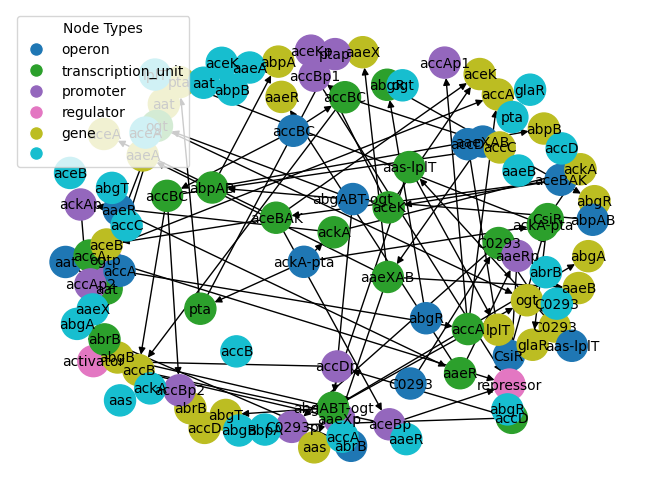

In [ ]:
G = nx.DiGraph() # Initialize a directed graph

# Process operon data
for operon in operon_data['data']['getAllOperon']['data']:
    operon_id = operon['operon']['_id']
    operon_name = operon['operon']['name']
    G.add_node(operon_id, label=operon_name, type='operon')

    for tu in operon['transcriptionUnits']:
        tu_id = tu['_id']
        tu_name = tu['name']
        G.add_node(tu_id, label=tu_name, type='transcription_unit')
        G.add_edge(operon_id, tu_id, relation='contains')

        if tu['promoter']:
            promoter_name = tu['promoter']['name']
            G.add_node(promoter_name, label=promoter_name, type='promoter')
            G.add_edge(tu_id, promoter_name, relation='regulated_by')

            for site in tu['promoter']['regulatorBindingSites']:
                regulator_function = site['function']
                G.add_node(regulator_function, label=regulator_function, type='regulator')
                G.add_edge(promoter_name, regulator_function, relation='binds_to')

        for gene in tu['genes']:
            gene_name = gene['name']
            G.add_node(gene_name, label=gene_name, type='gene')
            G.add_edge(tu_id, gene_name, relation='contains')

# Process gene data and include gene type
for gene_detail in genes_details:
    gene_data = gene_detail['data']['getGenesBy']['data'][0]['gene']
    gene_id = gene_data['_id']
    gene_name = gene_data['name']
    gene_type = gene_data['type']
    G.add_node(gene_id, label=gene_name, type=gene_type)

# Create table displaying relationships
edges = []
for u, v, data in G.edges(data=True):
    edges.append({
        "Source": G.nodes[u]['label'],
        "Source Type": G.nodes[u]['type'],
        "Target": G.nodes[v]['label'],
        "Target Type": G.nodes[v]['type'],
        "Relation": data['relation']
    })

# Convert to DataFrame
edges_df = pd.DataFrame(edges)
print(edges_df)

# Save DataFrame to CSV
edges_df.to_csv('relationships.csv', index=False)

# Visualize the graph
pos = nx.spring_layout(G, k=0.5, iterations=20)
labels = nx.get_node_attributes(G, 'label')
node_colors = [G.nodes[node]['type'] for node in G.nodes]

# Map node types to numerical values for color mapping
type_to_color = {'operon': 0, 'transcription_unit': 1, 'promoter': 2, 'regulator': 3, 'gene': 4, None:5}
numeric_node_colors = [type_to_color[t] for t in node_colors]

# Use a colormap
cmap = plt.cm.get_cmap('tab10', len(type_to_color))
nx.draw(G, pos, labels=labels, with_labels=True,
        node_color=numeric_node_colors,  # Pass numerical values
        cmap=cmap, node_size=500, font_size=10)

# Create a legend
legend_labels = list(type_to_color.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', label=t,
                      markerfacecolor=cmap(i), markersize=10)
           for i, t in enumerate(legend_labels)]
plt.legend(handles=handles, title='Node Types')

plt.show()

In [ ]:
import requests
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def fetch_operon_data(gene_name):
    url = ' https://a846-41-79-97-5.ngrok-free.app/graphql'
    query = """
    query ($geneName: String!) {
      getOperonBy(search: $geneName) {
        data {
          operon {
            _id
            name
            strand
          }
          transcriptionUnits {
            name
            promoter {
              name
              confidenceLevel
              regulatorBindingSites {
                function
              }
            }
            genes {
              name
            }
          }
        }
      }
    }
    """
    headers = {'Content-Type': 'application/json'}
    payload = {'query': query, 'variables': {'geneName': gene_name}}

    response = requests.post(url, json=payload, headers=headers)
    if response.status_code == 200:
        data = response.json()
        # Check if data is present
        if data['data']['getOperonBy']['data']:
            return data
        else:
            print("No data found for the given gene name.")
            return None
    else:
        print(f"Query failed to run with a {response.status_code}.")
        print(response.text)
        return None

def load_gene_data(csv_file):
    return pd.read_csv(csv_file)


# Example usage
gene_name = input("Please enter the gene name: ")
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
gene_data = load_gene_data(csv_file)
operon_data = fetch_operon_data(gene_name)


Please enter the gene name: mutL


In [ ]:
def integrate_data(gene_name, gene_data, operon_data):
    integrated_data = []
    gene_row = gene_data[gene_data['GeneName'] == gene_name]
    if gene_row.empty:
        print(f"Gene {gene_name} not found in the gene data file.")
        return pd.DataFrame()

    gene_product = gene_row['GeneProduct'].values[0]

    for entry in operon_data['data']['getOperonBy']['data']:
        operon_name = entry['operon']['name']
        for tu in entry['transcriptionUnits']:
            # Check if promoter data exists before accessing it
            if tu.get('promoter'):
                for gene in tu['genes']:
                    gene_name = gene['name']
                    gene_row = gene_data[gene_data['GeneName'] == gene_name]
                    if not gene_row.empty:
                        promoter_seq = gene_row['PromoterSeq'].values[0]
                        integrated_data.append({
                            'operon_name': operon_name,
                            'gene_name': gene_name,
                            'promoter_name': tu['promoter']['name'],
                            'confidence_level': tu['promoter']['confidenceLevel'],
                            'regulator_functions': [rbs['function'] for rbs in tu['promoter']['regulatorBindingSites']],
                            'promoter_seq': promoter_seq
                        })

    return pd.DataFrame(integrated_data)
integrated_data = integrate_data(gene_name, gene_data, operon_data)


def calculate_gc_content(sequence):
    # Handle potential float values by converting to string first
    if isinstance(sequence, float):
        sequence = str(sequence)
    gc_count = sequence.count('G') + sequence.count('C')
    # Handle empty sequences to avoid ZeroDivisionError
    if len(sequence) == 0:
        return 0  # or any other appropriate default value
    return gc_count / len(sequence)

def prepare_features(data):
    # Apply the modified gc_content calculation
    data['gc_content'] = data['promoter_seq'].apply(calculate_gc_content)

    # Example: One-hot encode the confidence level
    encoder = OneHotEncoder()
    confidence_level_encoded = encoder.fit_transform(data[['confidence_level']]).toarray()

    # Example: Simple nucleotide encoding
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 1))
    seq_encoded = vectorizer.fit_transform(data['promoter_seq'].fillna('')).toarray()
    features = np.hstack([confidence_level_encoded, seq_encoded, data[['gc_content']].values])
    return features

features = prepare_features(integrated_data)
print(features)


[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 2.4000000e+01 2.2000000e+01
  1.3000000e+01 2.2000000e+01 1.2345679e-02]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 1.7000000e+01 1.6000000e+01
  2.7000000e+01 2.1000000e+01 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 2.4000000e+01 2.2000000e+01
  1.3000000e+01 2.2000000e+01 1.2345679e-02]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 1.7000000e+01 1.6000000e+01
  2.7000000e+01 2.1000000e+01 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 2.4000000e+01 2.2000

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Ensure the dummy target variable has both classes
# The previous method might have randomly generated only one class
while True:
    integrated_data['locus_tag'] = np.random.randint(0, 2, size=len(integrated_data))
    if len(np.unique(integrated_data['locus_tag'])) == 2:
        break

X = features
y = integrated_data['locus_tag'].values
num_splits = 2  # Adjust as needed
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break  # Use only the first split

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
print("Shape of y_prob:", y_prob.shape)  # Check if it has two columns

# Now you can safely access the second column if it exists
if y_prob.shape[1] == 2:
    y_prob_positive = y_prob[:, 1]
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_positive)}')
else:
    print("Warning: predict_proba output has only one column. Cannot calculate ROC-AUC.")

Shape of y_prob: (15, 2)
Accuracy: 0.6666666666666666
ROC-AUC: 0.7500000000000001


In [ ]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Function to query GraphQL
def query_graphql(endpoint, query, variables=None):
    headers = {'Content-Type': 'application/json'}
    response = requests.post(endpoint, json={"query": query, "variables": variables}, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed to run with a {response.status_code}. Response: {response.text}")

# Define the endpoint URL for the GraphQL API
endpoint = 'https://a846-41-79-97-5.ngrok-free.app/graphql'

# Query to get operons and their genes
operon_query = """
{
  getAllOperon(limit: 10) {
    data {
      operon {
        _id
        name
        strand
      }
      transcriptionUnits {
        _id
        name
        promoter {
          name
          confidenceLevel
          regulatorBindingSites {
            function
          }
        }
        genes {
          name
        }
      }
    }
  }
}
"""

operon_data = query_graphql(endpoint, operon_query)

# Extract gene names from operon data
gene_names = []
for operon in operon_data['data']['getAllOperon']['data']:
    for tu in operon['transcriptionUnits']:
        for gene in tu['genes']:
            gene_names.append(gene['name'])

# Query to get gene details by name
def get_gene_details_by_name(gene_name):
    query = """
    {
      getGenesBy(search: "%s") {
        data {
          gene {
            _id
            name
            leftEndPosition
            rightEndPosition
            type
          }
        }
      }
    }
    """ % gene_name
    return query_graphql(endpoint, query)

# Get details for each gene
genes_details = []
for gene_name in gene_names:
    gene_details = get_gene_details_by_name(gene_name)
    genes_details.append(gene_details)
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
gene_data = pd.read_csv(csv_file)


Please enter the gene name: ada
  operon_name gene_name                                       gene_product  \
0    ada-alkB      alkB                          DNA oxidative demethylase   
1    ada-alkB       ada  DNA-binding transcriptional dual regulator/DNA...   
2    ada-alkB      alkB                          DNA oxidative demethylase   
3    ada-alkB       ada  DNA-binding transcriptional dual regulator/DNA...   
4    ada-alkB      alkB                          DNA oxidative demethylase   

  promoter_name confidence_level     regulator_functions  \
0         adap2                S  [repressor, activator]   
1         adap2                S  [repressor, activator]   
2          adap                S  [activator, repressor]   
3          adap                S  [activator, repressor]   
4         alkBp                W                      []   

                                        promoter_seq  
0  aaagcggtacgggccgttgccagcgcctgtgccgccaacaagctgg...  
1  aaaaattaaagcgcaagattgttgg

<ipython-input-42-034e17c4b053>:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(type_to_color))


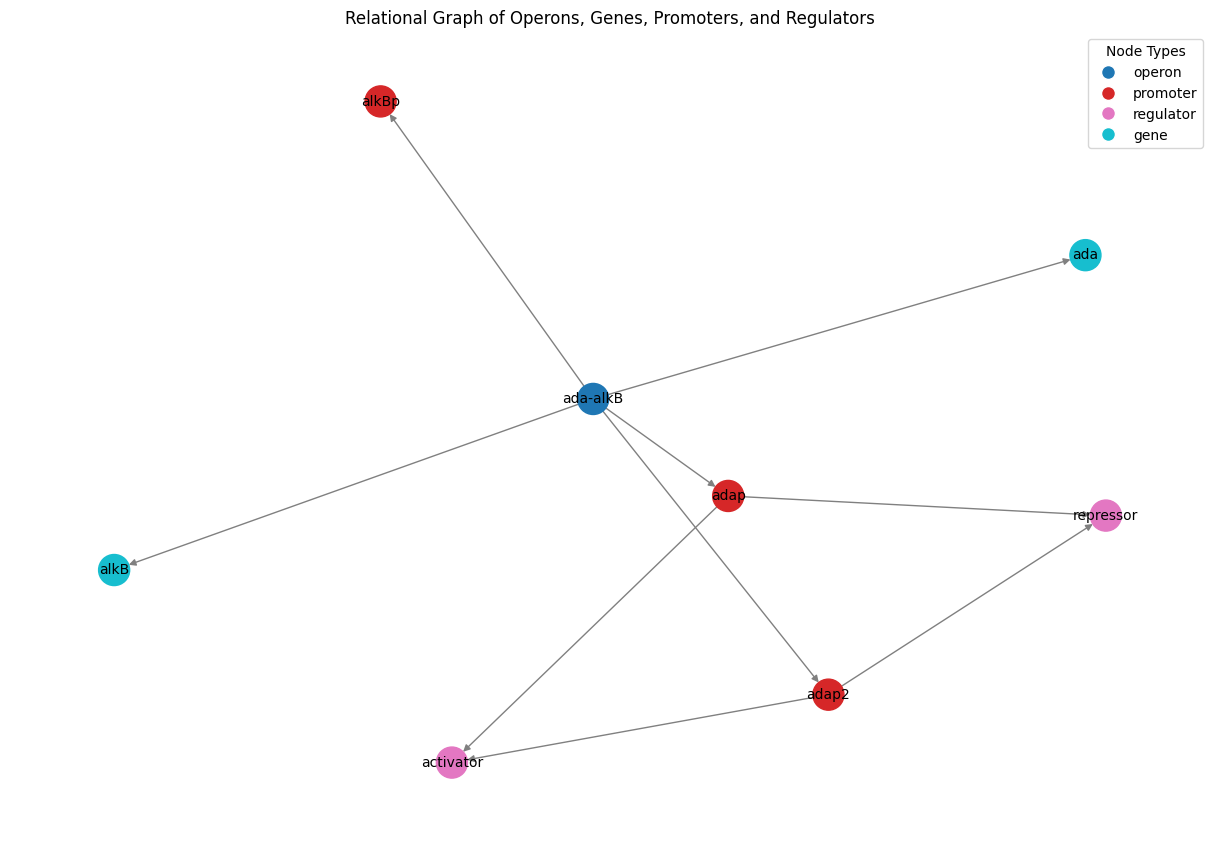

In [ ]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Function to query GraphQL
def query_graphql(endpoint, query, variables=None):
    headers = {'Content-Type': 'application/json'}
    response = requests.post(endpoint, json={"query": query, "variables": variables}, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed to run with a {response.status_code}. Response: {response.text}")

# Function to load gene data from CSV
def load_gene_data(csv_file):
    return pd.read_csv(csv_file)

# Define the endpoint URL for the GraphQL API
endpoint = 'https://a846-41-79-97-5.ngrok-free.app/graphql'

# Query to get operons and their genes
operon_query = """
{
  getAllOperon(limit: 10) {
    data {
      operon {
        _id
        name
        strand
      }
      transcriptionUnits {
        _id
        name
        promoter {
          name
          confidenceLevel
          regulatorBindingSites {
            function
          }
        }
        genes {
          name
        }
      }
    }
  }
}
"""

# Function to fetch operon data
def fetch_operon_data(gene_name):
    query = """
    {
      getOperonBy(search: "%s") {
        data {
          operon {
            _id
            name
            strand
          }
          transcriptionUnits {
            name
            promoter {
              name
              confidenceLevel
              regulatorBindingSites {
                function
              }
            }
            genes {
              name
            }
          }
        }
      }
    }
    """ % gene_name
    return query_graphql(endpoint, query)

# Function to integrate data
def integrate_data(operon_data, gene_data):
    G = nx.DiGraph()
    integrated_data = []
    results = []

    for operon in operon_data['data']['getOperonBy']['data']:
        operon_id = operon['operon']['_id']
        operon_name = operon['operon']['name']
        G.add_node(operon_id, label=operon_name, type='operon')

        for tu in operon['transcriptionUnits']:
            if tu['promoter']:
                promoter_name = tu['promoter']['name']
                confidence_level = tu['promoter']['confidenceLevel']
                G.add_node(promoter_name, label=promoter_name, type='promoter')
                G.add_edge(operon_id, promoter_name, relation='regulated_by')

                regulator_functions = []
                if 'regulatorBindingSites' in tu['promoter']:
                    for site in tu['promoter']['regulatorBindingSites']:
                        regulator_function = site['function']
                        G.add_node(regulator_function, label=regulator_function, type='regulator')
                        G.add_edge(promoter_name, regulator_function, relation='binds_to')
                        regulator_functions.append(regulator_function)

            for gene in tu['genes']:
                gene_name = gene['name']
                G.add_node(gene_name, label=gene_name, type='gene')
                G.add_edge(operon_id, gene_name, relation='contains')

                gene_row = gene_data[gene_data['GeneName'] == gene_name]
                if not gene_row.empty:
                    gene_product = gene_row['GeneProduct'].values[0]
                    promoter_seq = gene_row['PromoterSeq'].values[0]
                    predicted_class = "some_classification"  # Add logic to predict class
                    related_genes = [g['name'] for g in tu['genes']]
                    result = (f"This gene '{gene_name}' belongs to the operon '{operon_name}', "
                              f"it can be used in genetic circuits with these different genes: {', '.join(related_genes)}, "
                              f"it belongs to the '{predicted_class}' class and the promoter is: '{promoter_name}'.")
                    results.append(result)
                    integrated_data.append({
                        'operon_name': operon_name,
                        'gene_name': gene_name,
                        'gene_product': gene_product,
                        'promoter_name': promoter_name,
                        'confidence_level': confidence_level,
                        'regulator_functions': regulator_functions,
                        'promoter_seq': promoter_seq
                    })
    return G, pd.DataFrame(integrated_data), results

# Example usage
gene_name = input("Please enter the gene name: ")
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
gene_data = load_gene_data(csv_file)
operon_data = fetch_operon_data(gene_name)

if operon_data:
    G, integrated_data, results = integrate_data(operon_data, gene_data)
    print(integrated_data.head())
    integrated_data.to_csv('integrated_data.csv', index=False)
    for result in results:
        print(result)
else:
    print("No operon data available.")

# Visualize the graph
pos = nx.spring_layout(G, k=0.5, iterations=20)
labels = nx.get_node_attributes(G, 'label')
node_colors = [G.nodes[node]['type'] for node in G.nodes]

# Map node types to numerical values for color mapping
type_to_color = {'operon': 0, 'promoter': 1, 'regulator': 2, 'gene': 3}
numeric_node_colors = [type_to_color[t] for t in node_colors]

# Use a colormap
cmap = plt.cm.get_cmap('tab10', len(type_to_color))
plt.figure(figsize=(12, 8))
nx.draw(G, pos, labels=labels, with_labels=True,
        node_color=numeric_node_colors,  # Pass numerical values
        cmap=cmap, node_size=500, font_size=10, edge_color='gray')

# Create a legend
legend_labels = list(type_to_color.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', label=t,
                      markerfacecolor=cmap(i), markersize=10)
           for i, t in enumerate(legend_labels)]
plt.legend(handles=handles, title='Node Types')

plt.title('Relational Graph of Operons, Genes, Promoters, and Regulators')
plt.show()


Please enter the gene name: ada
  operon_name gene_name                                       gene_product  \
0    ada-alkB      alkB                          DNA oxidative demethylase   
1    ada-alkB       ada  DNA-binding transcriptional dual regulator/DNA...   
2    ada-alkB      alkB                          DNA oxidative demethylase   
3    ada-alkB       ada  DNA-binding transcriptional dual regulator/DNA...   
4    ada-alkB      alkB                          DNA oxidative demethylase   

  promoter_name confidence_level     regulator_functions  \
0         adap2                S  [repressor, activator]   
1         adap2                S  [repressor, activator]   
2          adap                S  [activator, repressor]   
3          adap                S  [activator, repressor]   
4         alkBp                W                      []   

                                        promoter_seq  
0  aaagcggtacgggccgttgccagcgcctgtgccgccaacaagctgg...  
1  aaaaattaaagcgcaagattgttgg

<ipython-input-69-887b5209a5d0>:184: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(type_to_color))


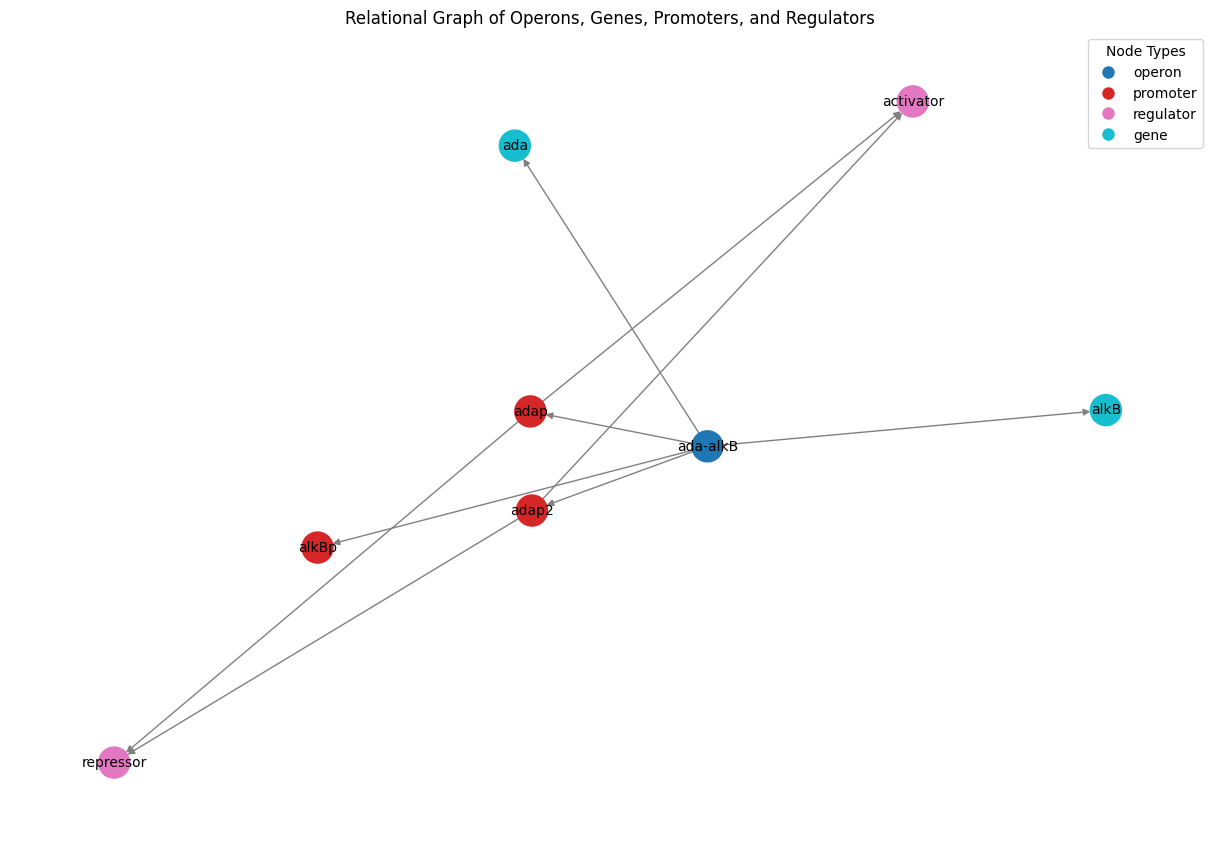

In [ ]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

# Function to query GraphQL
def query_graphql(endpoint, query, variables=None):
    headers = {'Content-Type': 'application/json'}
    response = requests.post(endpoint, json={"query": query, "variables": variables}, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed to run with a {response.status_code}. Response: {response.text}")

# Function to load gene data from CSV
def load_gene_data(csv_file):
    return pd.read_csv(csv_file)

# Define the endpoint URL for the GraphQL API
endpoint = 'https://a846-41-79-97-5.ngrok-free.app/graphql'

# Query to get operons and their genes
operon_query = """
{
  getAllOperon(limit: 10) {
    data {
      operon {
        _id
        name
        strand
      }
      transcriptionUnits {
        _id
        name
        promoter {
          name
          confidenceLevel
          regulatorBindingSites {
            function
          }
        }
        genes {
          name
        }
      }
    }
  }
}
"""

# Function to fetch operon data
def fetch_operon_data(gene_name):
    query = """
    {
      getOperonBy(search: "%s") {
        data {
          operon {
            _id
            name
            strand
          }
          transcriptionUnits {
            name
            promoter {
              name
              confidenceLevel
              regulatorBindingSites {
                function
              }
            }
            genes {
              name
            }
          }
        }
      }
    }
    """ % gene_name
    return query_graphql(endpoint, query)

# Function to integrate data
def integrate_data(operon_data, gene_data):
    G = nx.DiGraph()
    integrated_data = []
    results = []

    for operon in operon_data['data']['getOperonBy']['data']:
        operon_id = operon['operon']['_id']
        operon_name = operon['operon']['name']
        G.add_node(operon_id, label=operon_name, type='operon')

        for tu in operon['transcriptionUnits']:
            if tu['promoter']:
                promoter_name = tu['promoter']['name']
                confidence_level = tu['promoter']['confidenceLevel']
                G.add_node(promoter_name, label=promoter_name, type='promoter')
                G.add_edge(operon_id, promoter_name, relation='regulated_by')

                regulator_functions = []
                if 'regulatorBindingSites' in tu['promoter']:
                    for site in tu['promoter']['regulatorBindingSites']:
                        regulator_function = site['function']
                        G.add_node(regulator_function, label=regulator_function, type='regulator')
                        G.add_edge(promoter_name, regulator_function, relation='binds_to')
                        regulator_functions.append(regulator_function)

            for gene in tu['genes']:
                gene_name = gene['name']
                G.add_node(gene_name, label=gene_name, type='gene')
                G.add_edge(operon_id, gene_name, relation='contains')

                gene_row = gene_data[gene_data['GeneName'] == gene_name]
                if not gene_row.empty:
                    gene_product = gene_row['GeneProduct'].values[0]
                    promoter_seq = gene_row['PromoterSeq'].values[0]
                    predicted_class = classify_gene_name(gene_name)[1]
                    related_genes = [g['name'] for g in tu['genes']]
                    result = (f"This gene '{gene_name}' belongs to the operon '{operon_name}', "
                              f"it can be used in genetic circuits with these different genes: {', '.join(related_genes)}, "
                              f"it belongs to the '{predicted_class}' class and the promoter is: '{promoter_name}'.")
                    results.append(result)
                    integrated_data.append({
                        'operon_name': operon_name,
                        'gene_name': gene_name,
                        'gene_product': gene_product,
                        'promoter_name': promoter_name,
                        'confidence_level': confidence_level,
                        'regulator_functions': regulator_functions,
                        'promoter_seq': promoter_seq
                    })
    return G, pd.DataFrame(integrated_data), results

# Define the classifier and vectorizer
gene_to_product = {
    "mutL": "Mismatch repair enzyme"
    # Add more gene to gene product mappings as needed
}

label_encoder = LabelEncoder()
labels = ["class1", "class2", "class3"]  # Replace with your actual class labels
label_encoder.fit(labels)

tfidf_vectorizer = TfidfVectorizer()
clf = SVC(probability=True)

def classify_gene_name(gene_name):
    gene_product = gene_to_product.get(gene_name, "")
    if gene_product == "":
        return "Unknown gene name"
    features = tfidf_vectorizer.transform([gene_product])
    # Predict the class
    predicted_class = clf.predict(features)
    # Return the gene product and the predicted class label
    return gene_product, label_encoder.inverse_transform(predicted_class)[0]

# Example usage
gene_name = input("Please enter the gene name: ")
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
gene_data = load_gene_data(csv_file)
operon_data = fetch_operon_data(gene_name)

if operon_data:
    G, integrated_data, results = integrate_data(operon_data, gene_data)
    print(integrated_data.head())
    integrated_data.to_csv('integrated_data.csv', index=False)
    for result in results:
        print(result)
else:
    print("No operon data available.")

# Visualize the graph
pos = nx.spring_layout(G, k=0.5, iterations=20)
labels = nx.get_node_attributes(G, 'label')
node_colors = [G.nodes[node]['type'] for node in G.nodes]

# Map node types to numerical values for color mapping
type_to_color = {'operon': 0, 'promoter': 1, 'regulator': 2, 'gene': 3}
numeric_node_colors = [type_to_color[t] for t in node_colors]

# Use a colormap
cmap = plt.cm.get_cmap('tab10', len(type_to_color))
plt.figure(figsize=(12, 8))
nx.draw(G, pos, labels=labels, with_labels=True,
        node_color=numeric_node_colors,  # Pass numerical values
        cmap=cmap, node_size=500, font_size=10, edge_color='gray')

# Create a legend
legend_labels = list(type_to_color.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', label=t,
                      markerfacecolor=cmap(i), markersize=10)
           for i, t in enumerate(legend_labels)]
plt.legend(handles=handles, title='Node Types')

plt.title('Relational Graph of Operons, Genes, Promoters, and Regulators')
plt.show()


In [ ]:
import re # import the regular expression module
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove non-alphanumeric characters
    return text

data['GeneProduct'] = data['GeneProduct'].apply(preprocess_text)

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Extract features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['GeneProduct']).toarray()
y = data['GeneProduct'].apply(lambda x: 'binding' if 'binding' in x else ('transcription' if 'transcription' in x else ('translation' if 'translation' in x else 'other')))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the GA parameters
population_size = 50
generations = 20
mutation_rate = 0.1

# Define the fitness function
def fitness_function(solution):
    selected_features = np.where(solution == 1)[0]
    if len(selected_features) == 0:
        return 0
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]
    clf = MultinomialNB()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    return accuracy_score(y_test, y_pred)

# Initialize the population
population = np.random.randint(2, size=(population_size, X_train.shape[1]))

# Run the GA
for generation in range(generations):
    fitness_scores = np.array([fitness_function(solution) for solution in population])
    best_solution = population[np.argmax(fitness_scores)]
    next_population = []
    for _ in range(population_size // 2):
        # Select parents
        parents = population[np.random.choice(np.arange(population_size), size=2, p=fitness_scores/fitness_scores.sum())]
        # Crossover
        crossover_point = np.random.randint(1, X_train.shape[1])
        offspring1 = np.concatenate((parents[0][:crossover_point], parents[1][crossover_point:]))
        offspring2 = np.concatenate((parents[1][:crossover_point], parents[0][crossover_point:]))
        # Mutation
        for offspring in [offspring1, offspring2]:
            if np.random.rand() < mutation_rate:
                mutation_point = np.random.randint(X_train.shape[1])
                offspring[mutation_point] = 1 - offspring[mutation_point]
            next_population.append(offspring)
    population = np.array(next_population)

# Get the best solution from the final population
best_solution = population[np.argmax([fitness_function(solution) for solution in population])]
selected_features = np.where(best_solution == 1)[0]


In [ ]:
# Train and evaluate model function
def train_and_evaluate_model(X_train, X_test, y_train, y_test, selected_features):
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]
    clf = MultinomialNB()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    return clf

# Recommend genes function
def recommend_genes(data, function):
    matching_genes = data[data['GeneProduct'].str.contains(function)]['GeneName'].tolist()
    return matching_genes

# Assuming `data`, `X_train`, `X_test`, `y_train`, `y_test`, and `selected_features` are already defined
clf = train_and_evaluate_model(X_train, X_test, y_train, y_test, selected_features)

# Example usage of recommend_genes
desired_functions = ["transcription", "protein"]
for function in desired_functions:
    recommended_genes = recommend_genes(data, function)
    print(f"Genes for {function}: {recommended_genes}")

Accuracy: 0.98
Genes for transcription: ['aaeR', 'aaeR', 'aaeR', 'aaeR', 'aaeR', 'acrR', 'ada', 'adiY', 'agaR', 'alaS', 'allR', 'allS', 'alsR', 'alsR', 'appY', 'appY', 'araC', 'arcA', 'arcA', 'arcA', 'arcA', 'arcA', 'arcA', 'arcA', 'argP', 'argR', 'argR', 'arsR', 'ascG', 'asnC', 'bdcR', 'betI', 'bglG', 'bglG', 'bluR', 'bolA', 'bolA', 'cadC', 'caiF', 'cbl', 'cdaR', 'cecR', 'comR', 'comR', 'cpxR', 'crp', 'crp', 'crp', 'csgD', 'csgD', 'csiR', 'csiR', 'cspE', 'cspE', 'cueR', 'cusR', 'cynR', 'cysB', 'cytR', 'dcuR', 'deoR', 'dhaR', 'dicC', 'dinJ', 'dksA', 'dksA', 'dksA', 'dmlR', 'dsdC', 'ebgR', 'envR', 'envR', 'envR', 'envR', 'envR', 'envR', 'evgA', 'evgA', 'exuR', 'exuR', 'fadR', 'fadR', 'feaR', 'feaR', 'feaR', 'feaR', 'fimZ', 'flhC', 'flhD', 'flhD', 'fnr', 'fnr', 'frvR', 'fucR', 'fur', 'fur', 'gadE', 'gadE', 'gadE', 'gadE', 'gadW', 'gadW', 'gadX', 'galR', 'galS', 'gcvA', 'gcvR', 'gcvR', 'glcC', 'gntR', 'gntR', 'gntR', 'gntR', 'greA', 'greA', 'greB', 'greB', 'hcaR', 'crp', 'hdfR', 'hdfR', '

               precision    recall  f1-score   support

      binding       1.00      1.00      1.00       535
        other       0.95      1.00      0.98       570
      protein       1.00      0.96      0.98       564
    regulator       1.00      0.99      0.99       561
transcription       1.00      1.00      1.00       544

     accuracy                           0.99      2774
    macro avg       0.99      0.99      0.99      2774
 weighted avg       0.99      0.99      0.99      2774

Cross-validation scores: [0.97836668 0.99242834 0.99459167 0.996755   0.98864251]
Average cross-validation score: 0.9901568415359655
Please enter the gene name: ada
  operon_name gene_name                                       gene_product  \
0    ada-alkB      alkB                          DNA oxidative demethylase   
1    ada-alkB       ada  DNA-binding transcriptional dual regulator/DNA...   
2    ada-alkB      alkB                          DNA oxidative demethylase   
3    ada-alkB       ada  

<ipython-input-71-7c1d4018d04a>:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(type_to_color))


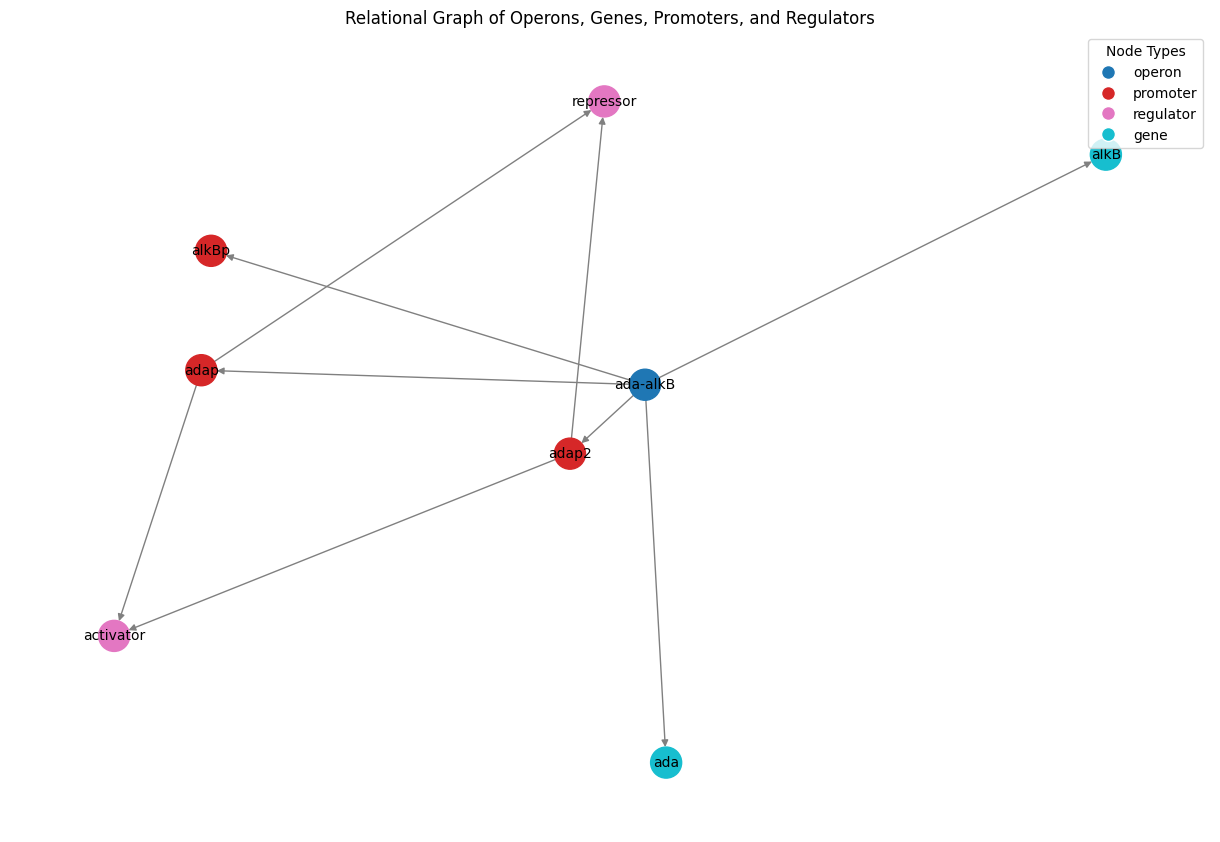

In [ ]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Function to query GraphQL
def query_graphql(endpoint, query, variables=None):
    headers = {'Content-Type': 'application/json'}
    response = requests.post(endpoint, json={"query": query, "variables": variables}, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed to run with a {response.status_code}. Response: {response.text}")

# Function to load gene data from CSV
def load_gene_data(csv_file):
    return pd.read_csv(csv_file)

# Define the endpoint URL for the GraphQL API
endpoint = 'https://a846-41-79-97-5.ngrok-free.app/graphql'

# Query to get operons and their genes
operon_query = """
{
  getAllOperon(limit: 10) {
    data {
      operon {
        _id
        name
        strand
      }
      transcriptionUnits {
        _id
        name
        promoter {
          name
          confidenceLevel
          regulatorBindingSites {
            function
          }
        }
        genes {
          name
        }
      }
    }
  }
}
"""

# Function to fetch operon data
def fetch_operon_data(gene_name):
    query = """
    {
      getOperonBy(search: "%s") {
        data {
          operon {
            _id
            name
            strand
          }
          transcriptionUnits {
            name
            promoter {
              name
              confidenceLevel
              regulatorBindingSites {
                function
              }
            }
            genes {
              name
            }
          }
        }
      }
    }
    """ % gene_name
    return query_graphql(endpoint, query)

# Define the target variable with extended classification
def classify_gene_product(gene_product):
    if 'binding' in gene_product:
        return 'binding'
    elif 'transcription' in gene_product:
        return 'transcription'
    elif 'protein' in gene_product:
        return 'protein'
    elif 'regulator' in gene_product:
        return 'regulator'
    elif 'DNA-binding' in gene_product:
        return 'DNA-binding'
    else:
        return 'other'

# Function to integrate data
def integrate_data(operon_data, gene_data, clf, label_encoder, tfidf_vectorizer):
    G = nx.DiGraph()
    integrated_data = []
    results = []

    for operon in operon_data['data']['getOperonBy']['data']:
        operon_id = operon['operon']['_id']
        operon_name = operon['operon']['name']
        G.add_node(operon_id, label=operon_name, type='operon')

        for tu in operon['transcriptionUnits']:
            if tu['promoter']:
                promoter_name = tu['promoter']['name']
                confidence_level = tu['promoter']['confidenceLevel']
                G.add_node(promoter_name, label=promoter_name, type='promoter')
                G.add_edge(operon_id, promoter_name, relation='regulated_by')

                regulator_functions = []
                if 'regulatorBindingSites' in tu['promoter']:
                    for site in tu['promoter']['regulatorBindingSites']:
                        regulator_function = site['function']
                        G.add_node(regulator_function, label=regulator_function, type='regulator')
                        G.add_edge(promoter_name, regulator_function, relation='binds_to')
                        regulator_functions.append(regulator_function)

            for gene in tu['genes']:
                gene_name = gene['name']
                G.add_node(gene_name, label=gene_name, type='gene')
                G.add_edge(operon_id, gene_name, relation='contains')

                gene_row = gene_data[gene_data['GeneName'] == gene_name]
                if not gene_row.empty:
                    gene_product = gene_row['GeneProduct'].values[0]
                    promoter_seq = gene_row['PromoterSeq'].values[0]
                    features = tfidf_vectorizer.transform([gene_product])
                    predicted_class = label_encoder.inverse_transform(clf.predict(features))[0]
                    related_genes = [g['name'] for g in tu['genes']]
                    result = (f"This gene '{gene_name}' belongs to the operon '{operon_name}', "
                              f"it can be used in genetic circuits with these different genes: {', '.join(related_genes)}, "
                              f"it belongs to the '{predicted_class}' class and the promoter is: '{promoter_name}'.")
                    results.append(result)
                    integrated_data.append({
                        'operon_name': operon_name,
                        'gene_name': gene_name,
                        'gene_product': gene_product,
                        'promoter_name': promoter_name,
                        'confidence_level': confidence_level,
                        'regulator_functions': regulator_functions,
                        'promoter_seq': promoter_seq
                    })
    return G, pd.DataFrame(integrated_data), results

# Load and prepare gene data
csv_file = '/content/drive/My Drive/Colab Notebooks/SynB/prokaryoteProm_updated2.csv'
gene_data = load_gene_data(csv_file)

# Extract the GeneProduct column and classify
gene_products = gene_data['GeneProduct']
tfidf_vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
X = tfidf_vectorizer.fit_transform(gene_products)

# Add classification column
gene_data['Class'] = gene_data['GeneProduct'].apply(classify_gene_product)

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(gene_data['Class'])

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
cross_val_scores = cross_val_score(clf, X_res, y_res, cv=5)
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Average cross-validation score: {cross_val_scores.mean()}")

# Example usage
gene_name = input("Please enter the gene name: ")
operon_data = fetch_operon_data(gene_name)

if operon_data:
    G, integrated_data, results = integrate_data(operon_data, gene_data, clf, label_encoder, tfidf_vectorizer)
    print(integrated_data.head())
    integrated_data.to_csv('integrated_data.csv', index=False)
    for result in results:
        print(result)
else:
    print("No operon data available.")

# Visualize the graph
pos = nx.spring_layout(G, k=0.5, iterations=20)
labels = nx.get_node_attributes(G, 'label')
node_colors = [G.nodes[node]['type'] for node in G.nodes]

# Map node types to numerical values for color mapping
type_to_color = {'operon': 0, 'promoter': 1, 'regulator': 2, 'gene': 3}
numeric_node_colors = [type_to_color[t] for t in node_colors]

# Use a colormap
cmap = plt.cm.get_cmap('tab10', len(type_to_color))
plt.figure(figsize=(12, 8))
nx.draw(G, pos, labels=labels, with_labels=True,
        node_color=numeric_node_colors,  # Pass numerical values
        cmap=cmap, node_size=500, font_size=10, edge_color='gray')

# Create a legend
legend_labels = list(type_to_color.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', label=t,
                      markerfacecolor=cmap(i), markersize=10)
           for i, t in enumerate(legend_labels)]
plt.legend(handles=handles, title='Node Types')

plt.title('Relational Graph of Operons, Genes, Promoters, and Regulators')
plt.show()
